## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
df = taxi_data.copy()

Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [4]:
df['pickup_datetime'] = df['pickup_datetime'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))

In [5]:
print('The earliest pickup date:', df['pickup_datetime'].apply(lambda x: x.date()).sort_values().iloc[0])
print('The latest pickup date:', df['pickup_datetime'].apply(lambda x: x.date()).sort_values().iloc[-1])

The earliest pickup date: 2016-01-01
The latest pickup date: 2016-06-30


Видим, что данные представлены от 01/01/2016 до 30/06/2016.

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


Видим, что в данных нет пропусков.

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [7]:
#a
print('Number of unique vendors:', df['vendor_id'].nunique())

#b
print('Maximum number of passengers:', df['passenger_count'].max())

#c
print('Mean trip duration in seconds:', int(np.round(df['trip_duration'].mean())))
print('Median trip duration in seconds:', int(np.round(df['trip_duration'].median())))

#d
print('Minimal trip duration in seconds:', df['trip_duration'].min())
print('Maximal trip duration in seconds:',df['trip_duration'].max())

Number of unique vendors: 2
Maximum number of passengers: 9
Mean trip duration in seconds: 959
Median trip duration in seconds: 662
Minimal trip duration in seconds: 1
Maximal trip duration in seconds: 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [8]:
def add_datetime_features(dataframe:pd.DataFrame, datetime_column:str = 'pickup_datetime') -> pd.DataFrame:
    """Adds datetime features to the provided dataframe such as the date of the pickup,
    the hour of the pickup and the day of the week of the pickup.

    Args:
        dataframe (pd.DataFrame): dataframe you wish to modify
        datetime_column (str, optional): name of the column with pickup datetime information. Defaults to 'pickup_datetime'.

    Returns:
        pd.DataFrame: modified dataframe
    """
    dataframe['pickup_date'] = dataframe[datetime_column].apply(lambda x: x.date())
    dataframe['pickup_hour'] = dataframe[datetime_column].apply(lambda x: x.hour)
    dataframe['pickup_day_of_week'] = dataframe[datetime_column].apply(lambda x: x.date().weekday())
    return dataframe

In [9]:
df = add_datetime_features(df)

In [10]:
print('Rides on Saturday:',df[df['pickup_day_of_week']==5].shape[0])
print('Mean number of rides per day:',int(np.round(df['pickup_date'].value_counts().mean())))


Rides on Saturday: 220868
Mean number of rides per day: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [11]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

In [12]:
holiday_data['date'] = holiday_data['date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d').date())

In [13]:
def add_holiday_features(initial_data:pd.DataFrame, holiday_data:pd.DataFrame) -> pd.DataFrame:
    """Adds a column that states whether or not the ride occured during a holiday.
    
    Args:
        initial_data (pd.DataFrame): initial dataframe
        holiday_data (pd.DataFrame): dataframe with holiday information

    Returns:
        pd.DataFrame: updated dataframe with information on holidays
    """
    updated_data = initial_data.copy()
    updated_data['pickup_holiday'] = updated_data['pickup_date'].isin(holiday_data['date'])
    updated_data['pickup_holiday'] =  updated_data['pickup_holiday'].apply(lambda x: 1 if x == True else 0)
    return updated_data

In [14]:
df = add_holiday_features(df,holiday_data)

In [15]:
print('Median ride duration on a holiday:', int(np.round(df[df['pickup_holiday']==1]['trip_duration'].median())))

Median ride duration on a holiday: 585


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [16]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

In [17]:
def add_osrm_features(data:pd.DataFrame, osrm_data:pd.DataFrame) -> pd.DataFrame:
    """adds OSRM data to the dataframe

    Args:
        data (pd.DataFrame): initial dataframe
        osrm_data (pd.DataFrame): dataframe with OSRM information

    Returns:
        pd.DataFrame: dataframe with added columns (total_distance, total_travel_time, number_of_steps)
    """
    data = data.merge(osrm_data[['id','total_distance','total_travel_time','number_of_steps']], how = 'left', on='id')
    return data

In [18]:
df = add_osrm_features(df, osrm_data)

In [19]:
print('Difference in median time between real values and values provided by OSRM:',df['trip_duration'].median()-df['total_travel_time'].median())

Difference in median time between real values and values provided by OSRM: 372.5


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

Видим, что появилась одна строка с пропущенными значениями.

In [21]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [22]:
def add_geographical_features(initial_data:pd.DataFrame) -> pd.DataFrame:
    """Adds geographical features to the data such as haversine distance and angle between start and end points for each trip.

    Args:
        initial_data (pd.DataFrame): initial dataset

    Returns:
        pd.DataFrame: modified dataset with geographical features included in columns called 'haversine_distance' and 'direction'
    """
    modified_data = initial_data.copy()
    modified_data['haversine_distance'] = get_haversine_distance(modified_data.pickup_latitude, modified_data.pickup_longitude, modified_data.dropoff_latitude, modified_data.dropoff_longitude)
    modified_data['direction'] = get_angle_direction(modified_data.pickup_latitude, modified_data.pickup_longitude, modified_data.dropoff_latitude, modified_data.dropoff_longitude)
    return modified_data

In [23]:
df = add_geographical_features(df)

In [24]:
print('Median Haversine distance is', round(df['haversine_distance'].median(), 2))

Median Haversine distance is 2.09


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [25]:
def add_cluster_features(data: pd.DataFrame) -> pd.DataFrame:
    """Adds geographical clusters to the data. All locations are separated in 10 clusters.

    Args:
        data (pd.DataFrame): initial dataset

    Returns:
        pd.DataFrame: modified dataset with geographical clusters information included in a column called 'geo_cluster'
    """
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                        data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    
    data['geo_cluster'] = kmeans.predict(coords)
    return data

In [26]:
df = add_cluster_features(df)
print('The smallest cluster contains', list(df['geo_cluster'].value_counts())[-1], 'rides.')

The smallest cluster contains 2 rides.


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [27]:
weather_data = pd.read_csv('data/weather_data.csv')

In [28]:
def add_weather_features (data:pd.DataFrame, weather_data:pd.DataFrame) -> pd.DataFrame:
    """adds weather features to the initial dataframe

    Args:
        data (pd.DataFrame): initial dataframe
        weather_data (pd.DataFrame): dataset with information on weather conditions in NYC on needed dates

    Returns:
        pd.DataFrame: dataframe with added columns 'temperature', 'visibility', 'wind speed', 'precip', 'events'
    """
    weather_data['date']=pd.to_datetime(weather_data['date'])
    data['pickup_date'] = pd.to_datetime(data['pickup_date'])
    data = data.merge(weather_data[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']], how = 'left', left_on = ['pickup_date', 'pickup_hour'], right_on = ['date', 'hour'])
    data = data.drop(columns = ['date', 'hour'])
    
    return data

In [29]:
df = add_weather_features(df,weather_data)

In [30]:
print('Number of rides during snow:', df[df['events']=='Snow']['events'].shape[0])
print('Number of rides during snow:', round(df[df['events'].isna()].shape[0]/df.shape[0]*100, 2))


Number of rides during snow: 13126
Number of rides during snow: 0.82


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [89]:
def fill_null_weather_data(data:pd.DataFrame) -> pd.DataFrame:
    """fills in the missing weather data with respective median values

    Args:
        data (pd.DataFrame): initial dataframe

    Returns:
        pd.DataFrame: dataframe with filled-in missing values
    """
    
    columns_to_fill = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in columns_to_fill:
        data[col] = data[col].fillna(
        data.groupby('pickup_date')[col].transform('median')
        )
        
    data['events'] = data['events'].fillna('None')
    data['total_distance'] = data['total_distance'].fillna(data['total_distance'].median())
    data['total_travel_time'] = data['total_travel_time'].fillna(data['total_travel_time'].median())
    data['number_of_steps'] = data['number_of_steps'].fillna(data['number_of_steps'].median())
    
    return data

In [32]:
df = fill_null_weather_data(df)

In [33]:
print('Median temperature is', round(df['temperature'].median(),1))

Median temperature is 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


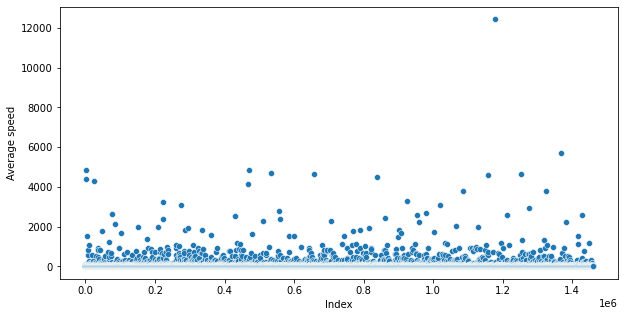

In [34]:
avg_speed = df['total_distance'] / df['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [35]:
too_long_ind = df[df['trip_duration']>24*60*60].index
print ('Number of rides longer than 24h is', len(too_long_ind))
df = df.drop(index=too_long_ind)

Number of rides longer than 24h is 4


In [36]:
too_fast_ind = df[df['total_distance']/(df['trip_duration']/3.6) > 300].index
print ('Number of rides with average speed over 300 km/h is', len(too_fast_ind))
df = df.drop(index=too_fast_ind)

Number of rides with average speed over 300 km/h is 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [37]:
df['trip_duration_log'] = np.log(df['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

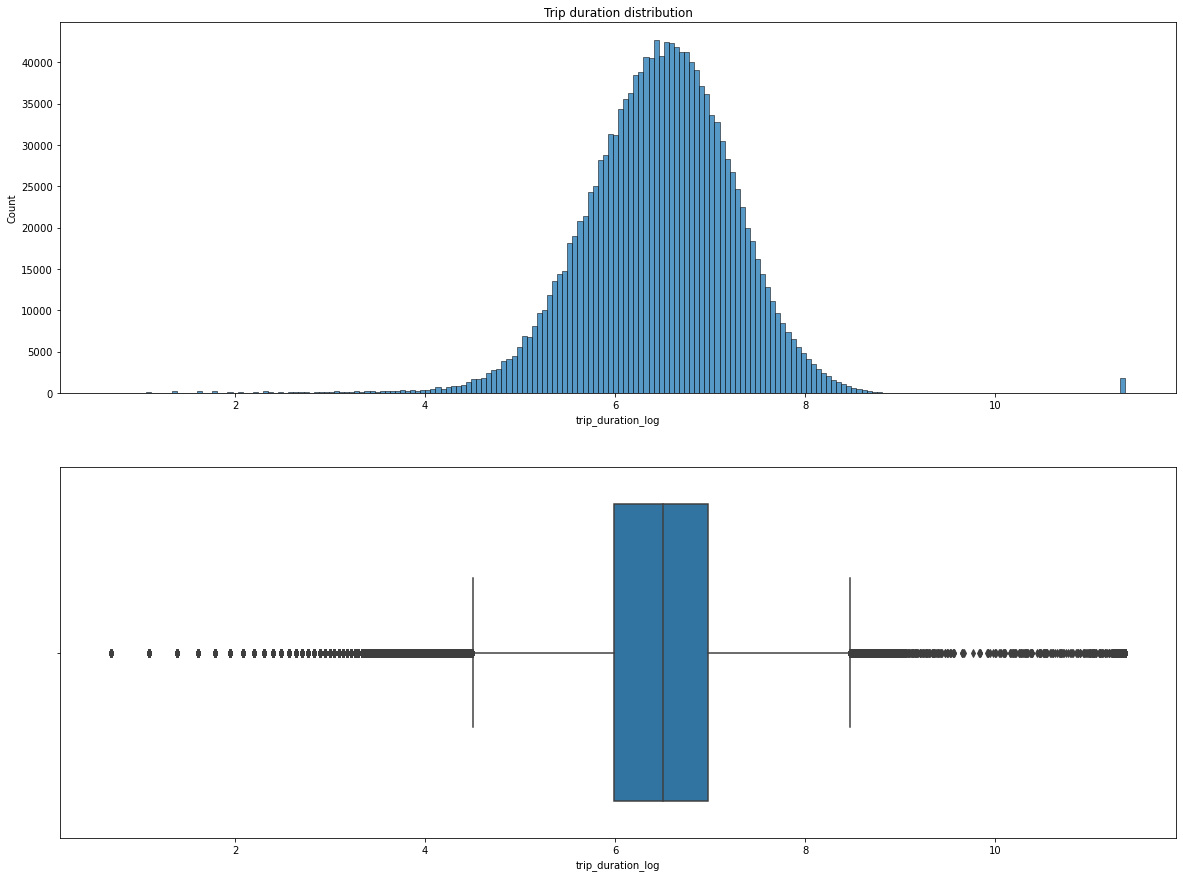

In [38]:
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.histplot(data = df['trip_duration_log'], bins=200, ax=ax[0])
ax[0].set_title('Trip duration distribution')
sns.boxplot(x = df['trip_duration_log'], ax=ax[1]);

In [39]:
H0 = 'The distribution is normal'
Ha = 'The distribution isn\'t normal'
alpha = 0.05
_,p = stats.normaltest(df['trip_duration_log'])

if p > alpha:
    print(H0)
else:
    print(Ha)
print('p-value: {0:.2f}'.format(p))

The distribution isn't normal
p-value: 0.00


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

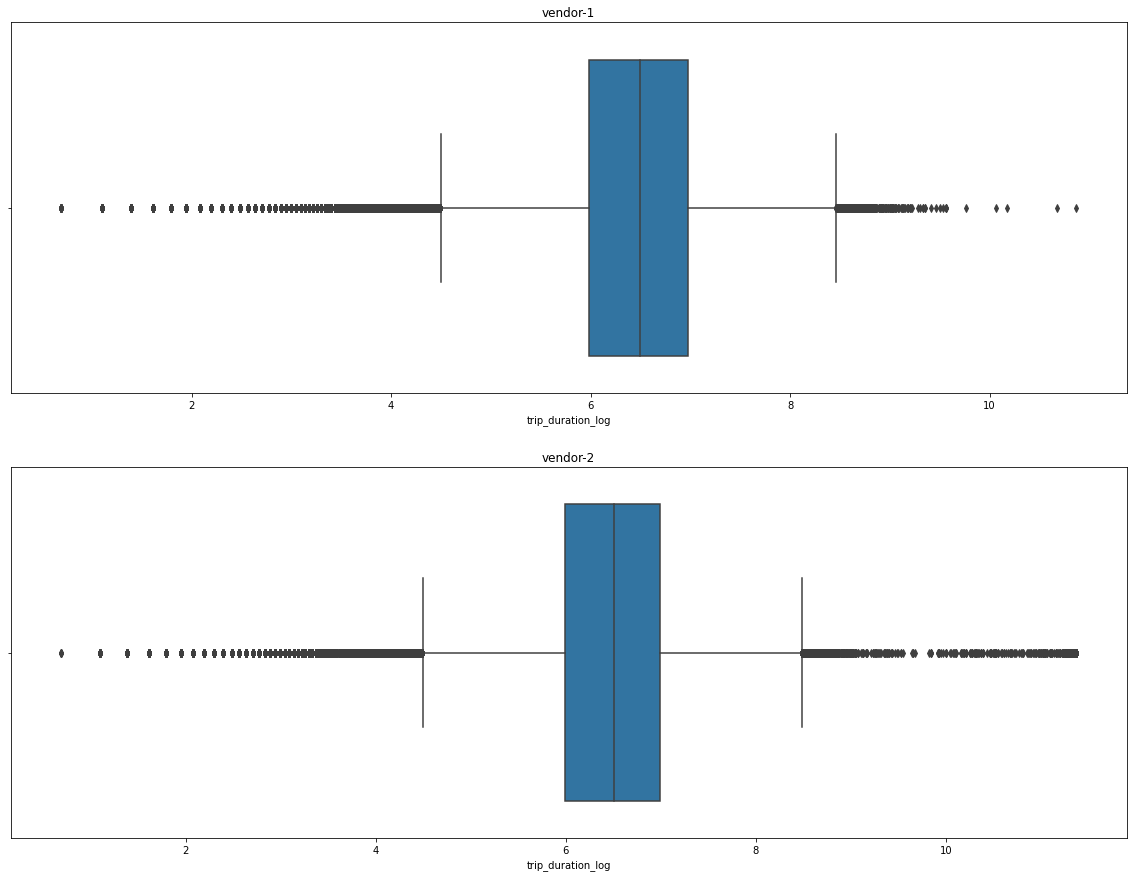

In [40]:
fig, ax = plt.subplots(df['vendor_id'].nunique(),1,figsize=(20,15))
for index, value in enumerate(df['vendor_id'].value_counts().sort_index().index):
    sns.boxplot(x = df[df['vendor_id']==value]['trip_duration_log'], ax=ax[index]);
    ax[index].set_title('vendor-' + str(value))

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

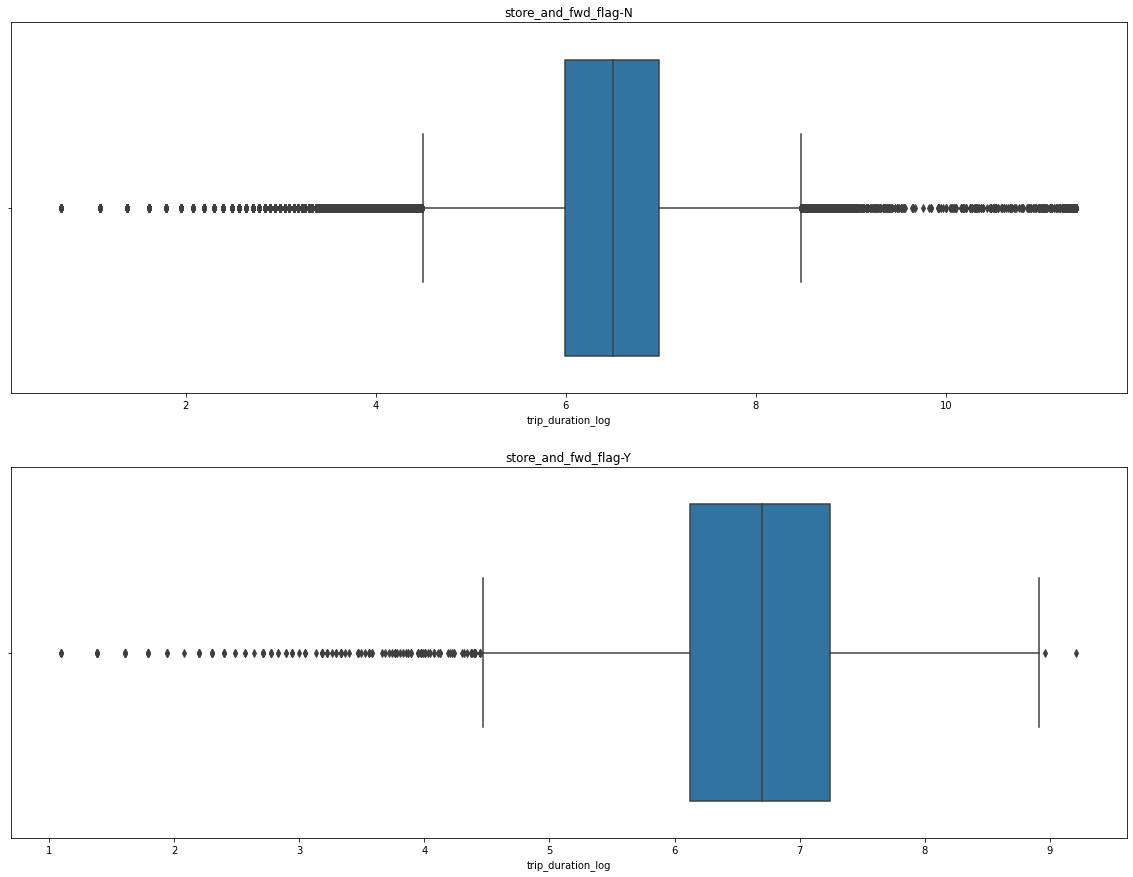

In [41]:
fig, ax = plt.subplots(df['store_and_fwd_flag'].nunique(),1,figsize=(20,15))
for index, value in enumerate(df['store_and_fwd_flag'].value_counts().sort_index().index):
    sns.boxplot(x = df[df['store_and_fwd_flag']==value]['trip_duration_log'], ax=ax[index]);
    ax[index].set_title('store_and_fwd_flag-' + str(value))

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

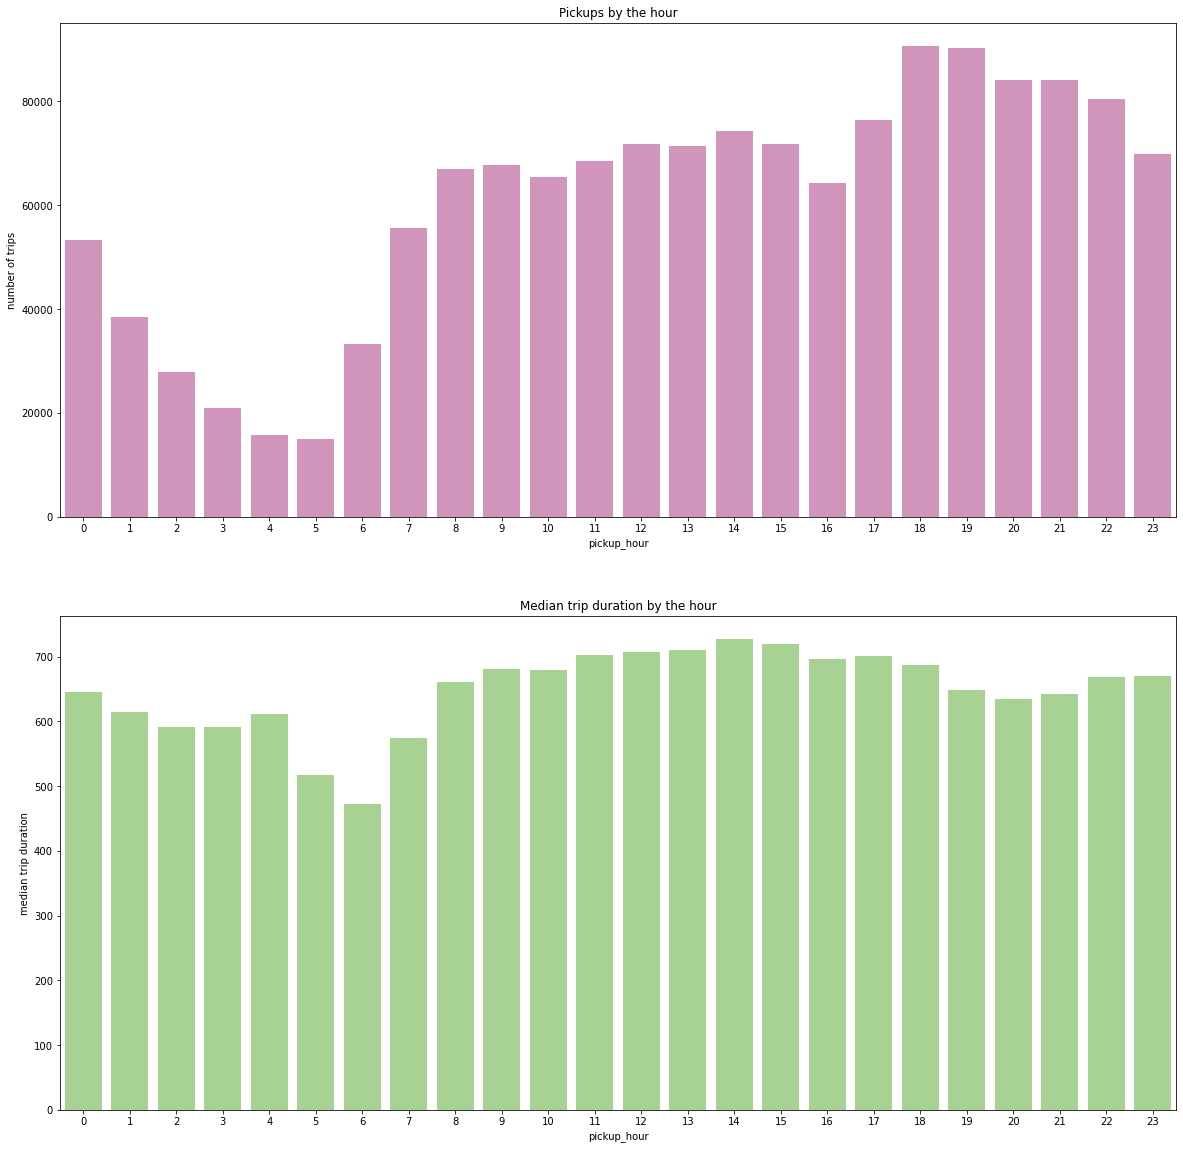

In [42]:
fig,ax = plt.subplots(2,1, figsize=(20,20))
hourly_pickups = df.groupby('pickup_hour')['vendor_id'].agg('count').reset_index().rename(columns = {'vendor_id':'number of trips'})
sns.barplot(x = hourly_pickups['pickup_hour'], y = hourly_pickups['number of trips'], color='#db8abe', ax = ax[0])
ax[0].set_title('Pickups by the hour')
median_trip_duration_by_hour = df.groupby('pickup_hour')['trip_duration'].agg('median').reset_index().rename(columns = {'trip_duration':'median trip duration'})
sns.barplot(x = median_trip_duration_by_hour['pickup_hour'], y = median_trip_duration_by_hour['median trip duration'], color='#a4db8a', ax = ax[1])
ax[1].set_title('Median trip duration by the hour');

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


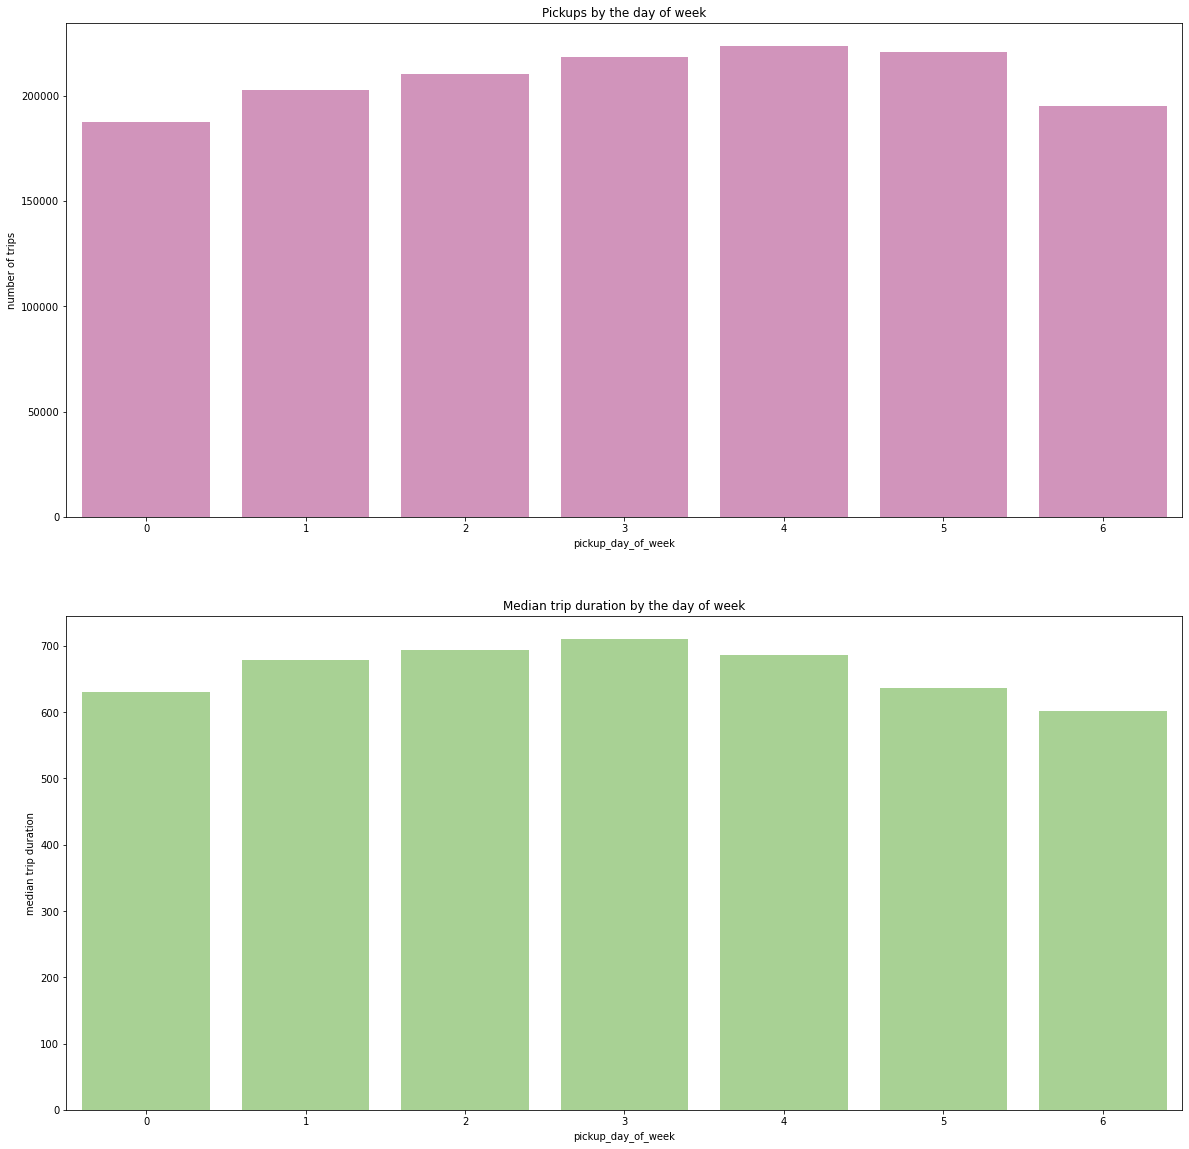

In [43]:
fig,ax = plt.subplots(2,1, figsize=(20,20))
hourly_pickups = df.groupby('pickup_day_of_week')['vendor_id'].agg('count').reset_index().rename(columns = {'vendor_id':'number of trips'})
sns.barplot(x = hourly_pickups['pickup_day_of_week'], y = hourly_pickups['number of trips'], color='#db8abe', ax = ax[0])
ax[0].set_title('Pickups by the day of week')
median_trip_duration_by_hour = df.groupby('pickup_day_of_week')['trip_duration'].agg('median').reset_index().rename(columns = {'trip_duration':'median trip duration'})
sns.barplot(x = median_trip_duration_by_hour['pickup_day_of_week'], y = median_trip_duration_by_hour['median trip duration'], color='#a4db8a', ax = ax[1])
ax[1].set_title('Median trip duration by the day of week');

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

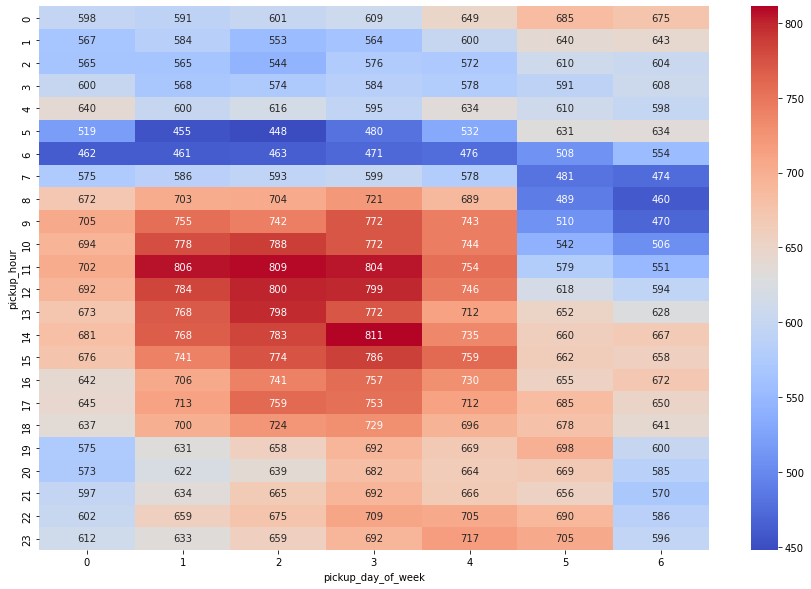

In [44]:
pivot_data = pd.pivot_table(data=df, index = 'pickup_hour', columns='pickup_day_of_week', values='trip_duration', aggfunc='median')
fig = plt.figure(figsize=(15,10))
sns.heatmap(pivot_data, cmap='coolwarm', annot= True, fmt = '.0f');

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


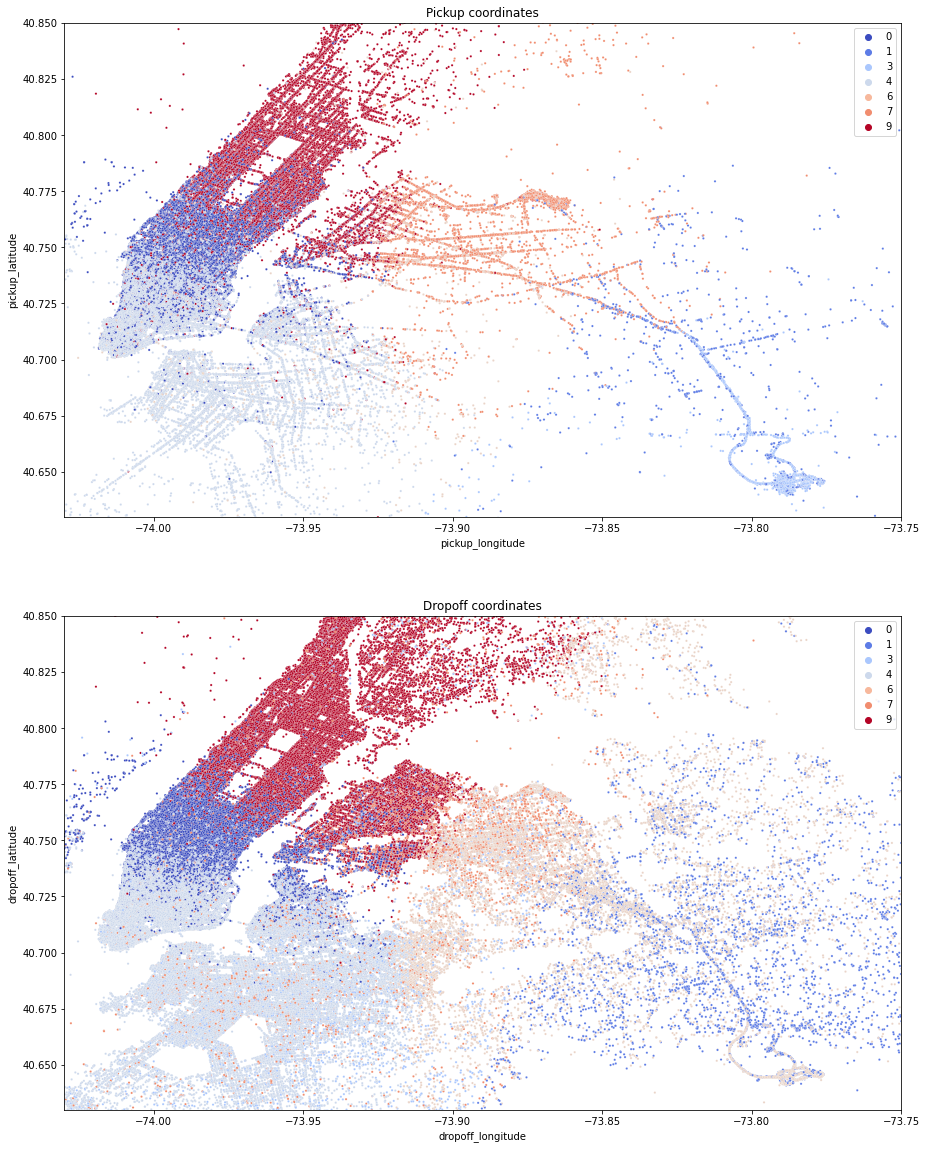

In [45]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig,ax = plt.subplots(2,1, figsize=(15,20))
sns.scatterplot(x = df['pickup_longitude'], y = df['pickup_latitude'], ax = ax[0], hue = df['geo_cluster'], s=5, palette = 'coolwarm')
ax[0].set_title('Pickup coordinates')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
ax[0].legend(loc = 'upper right')
sns.scatterplot(x = df['dropoff_longitude'], y = df['dropoff_latitude'], ax = ax[1], hue = df['geo_cluster'], s=5, palette = 'coolwarm')
ax[1].set_title('Dropoff coordinates')
ax[1].set_xlim(city_long_border)
ax[1].set_ylim(city_lat_border)
ax[1].legend(loc = 'upper right');

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [46]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458644, 11)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [47]:
train_data = df.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [48]:
train_data = train_data.drop(columns=['id', 'dropoff_datetime'])

In [49]:
train_data.shape

(1458233, 25)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [50]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [51]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print(round(train_data['vendor_id'].mean(),2))
print(round(train_data['store_and_fwd_flag'].mean(),3))

0.53
0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [52]:
one_hot_encoder = preprocessing.OneHotEncoder(sparse=False, drop = 'first')
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change])

In [53]:
column_names = one_hot_encoder.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns = column_names)

In [54]:
data_onehot.columns

Index(['pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
       'geo_cluster_1', 'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_4',
       'geo_cluster_5', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8',
       'geo_cluster_9', 'events_None', 'events_Rain', 'events_Snow'],
      dtype='object')

In [55]:
data_onehot.shape[1]

18

Добавим полученную таблицу с закодированными признаками:

In [56]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns = ['pickup_day_of_week', 'geo_cluster', 'events']), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [57]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [58]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [59]:
from sklearn.feature_selection import f_regression
selector = feature_selection.SelectKBest(score_func=f_regression, k = 25,)
z = selector.fit_transform(X_train,y_train_log)

In [60]:
best_features = selector.get_feature_names_out()
z = pd.DataFrame(z, columns = best_features)

In [61]:
X_train = X_train[best_features]
X_valid = X_valid[best_features]

In [62]:
best_features

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [63]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train,y_train_log)
X_train = pd.DataFrame(scaler.transform(X_train), columns=best_features)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=best_features)

In [64]:
round(X_valid['vendor_id'].mean(),2)

0.54

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [65]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train_log)
y_train_lin_reg_pred = lin_reg.predict(X_train)
y_valid_lin_reg_pred = lin_reg.predict(X_valid)
train_rmse = round(metrics.mean_squared_error(y_train_log, y_train_lin_reg_pred)**(1/2),2)
valid_rmse = round(metrics.mean_squared_error(y_valid_log, y_valid_lin_reg_pred)**(1/2),2)
print(f'Train RMSLE: {train_rmse}')
print(f'Validation RMSLE: {valid_rmse}')

Train RMSLE: 0.54
Validation RMSLE: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [66]:
poly = preprocessing.PolynomialFeatures(include_bias=False, degree=2)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.fit_transform(X_valid)

In [67]:
poly_normalizer = preprocessing.MinMaxScaler()
poly_normalizer.fit(X_train_poly,y_train_log)
X_train_poly = poly_normalizer.transform(X_train_poly)
X_valid_poly = poly_normalizer.transform(X_valid_poly)

In [68]:
poly_lin_reg = linear_model.LinearRegression()
poly_lin_reg.fit(X_train_poly, y_train_log)
y_train_poly_lin_reg_pred = poly_lin_reg.predict(X_train_poly)
y_valid_poly_lin_reg_pred = poly_lin_reg.predict(X_valid_poly)
train_poly_rmse = round(metrics.mean_squared_error(y_train_log, y_train_poly_lin_reg_pred)**(1/2),2)
valid_poly_rmse = round(metrics.mean_squared_error(y_valid_log, y_valid_poly_lin_reg_pred)**(1/2),2)
print(f'Train RMSLE: {train_poly_rmse}')
print(f'Validation RMSLE: {valid_poly_rmse}')

Train RMSLE: 0.47
Validation RMSLE: 0.7


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [69]:
from sklearn.linear_model import Ridge
l2_poly_reg = Ridge(alpha=1)
l2_poly_reg.fit(X_train_poly, y_train_log)
y_train_l2poly_lin_reg_pred = l2_poly_reg.predict(X_train_poly)
y_valid_l2poly_lin_reg_pred = l2_poly_reg.predict(X_valid_poly)
train_l2poly_rmse = round(metrics.mean_squared_error(y_train_log, y_train_l2poly_lin_reg_pred)**(1/2),2)
valid_l2poly_rmse = round(metrics.mean_squared_error(y_valid_log, y_valid_l2poly_lin_reg_pred)**(1/2),2)
print(f'Train RMSLE: {train_l2poly_rmse}')
print(f'Validation RMSLE: {valid_l2poly_rmse}')

Train RMSLE: 0.48
Validation RMSLE: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [70]:
tree_reg = tree.DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train_log)
y_train_tree_pred = tree_reg.predict(X_train)
y_valid_tree_pred = tree_reg.predict(X_valid)
train_tree_rmse = round(metrics.mean_squared_error(y_train_log, y_train_tree_pred)**(1/2),2)
valid_tree_rmse = round(metrics.mean_squared_error(y_valid_log, y_valid_tree_pred)**(1/2),2)
print(f'Train RMSLE: {train_tree_rmse}')
print(f'Validation RMSLE: {valid_tree_rmse}')

Train RMSLE: 0.0
Validation RMSLE: 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [71]:
rmsle_data = []
max_depths = range(7, 20)
for i in max_depths:
    tree_reg = tree.DecisionTreeRegressor(random_state=42, max_depth=i)
    tree_reg.fit(X_train, y_train_log)
    y_train_tree_pred = tree_reg.predict(X_train)
    y_valid_tree_pred = tree_reg.predict(X_valid)
    train_tree_rmse = round(metrics.mean_squared_error(y_train_log, y_train_tree_pred)**(1/2),3)
    valid_tree_rmse = round(metrics.mean_squared_error(y_valid_log, y_valid_tree_pred)**(1/2),3)
    rmsle_data.append([i,train_tree_rmse, valid_tree_rmse])

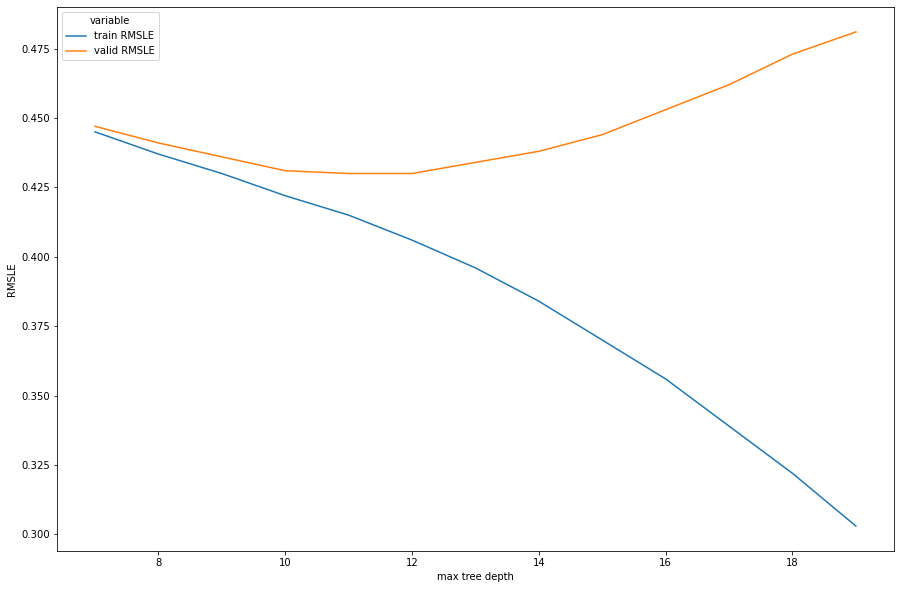

In [72]:
rmsle_data = pd.DataFrame(rmsle_data, columns = ['max tree depth', 'train RMSLE', 'valid RMSLE'])

fig= plt.figure(figsize = (15,10))
sns.lineplot(x ='max tree depth', y = 'RMSLE', hue = 'variable', data= pd.melt(rmsle_data, ['max tree depth']).rename(columns={'value':'RMSLE'}));

Видим, что оптимальная глубина 12

In [73]:
rmsle_data[rmsle_data['max tree depth'] == 12]

,max tree depth,train RMSLE,valid RMSLE
5,12,0.406,0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [74]:
forest_reg = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42)
forest_reg.fit(X_train, y_train_log)
y_train_forest_pred = forest_reg.predict(X_train)
y_valid_forest_pred = forest_reg.predict(X_valid)
train_forest_rmse = round(metrics.mean_squared_error(y_train_log, y_train_forest_pred)**(1/2),2)
valid_forest_rmse = round(metrics.mean_squared_error(y_valid_log, y_valid_forest_pred)**(1/2),2)
print(f'Train RMSLE: {train_forest_rmse}')
print(f'Validation RMSLE: {valid_forest_rmse}')

Train RMSLE: 0.4
Validation RMSLE: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [75]:
grad_boost_reg = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42)
grad_boost_reg.fit(X_train, y_train_log)
y_train_grad_boost_pred = grad_boost_reg.predict(X_train)
y_valid_grad_boost_pred = grad_boost_reg.predict(X_valid)
train_grad_boost_rmse = round(metrics.mean_squared_error(y_train_log, y_train_grad_boost_pred)**(1/2),2)
valid_grad_boost_rmse = round(metrics.mean_squared_error(y_valid_log, y_valid_grad_boost_pred)**(1/2),2)
print(f'Train RMSLE: {train_grad_boost_rmse}')
print(f'Validation RMSLE: {valid_grad_boost_rmse}')

Train RMSLE: 0.37
Validation RMSLE: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


<AxesSubplot:xlabel='feature', ylabel='importance'>

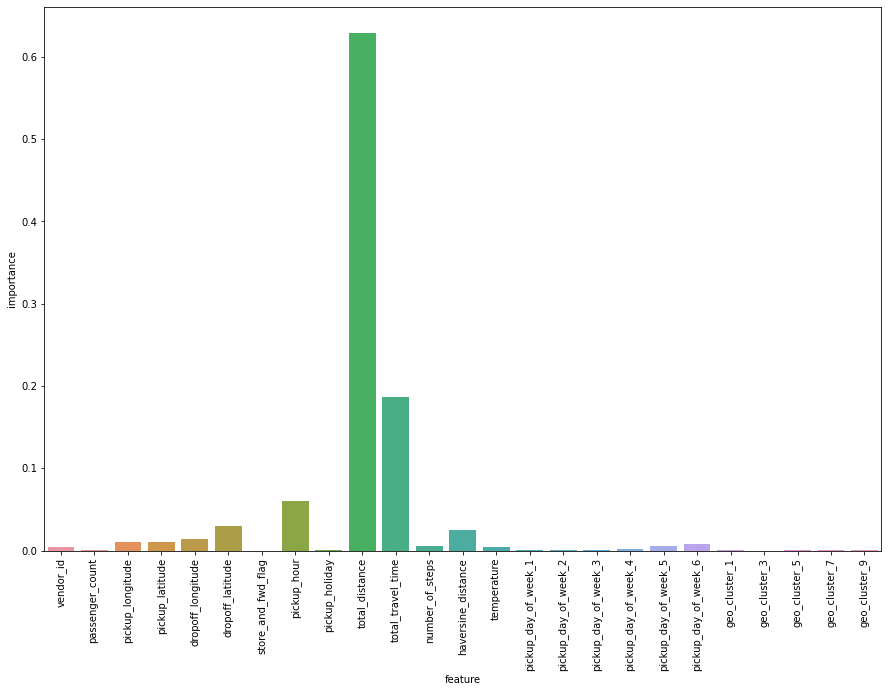

In [76]:
feature_importances = pd.DataFrame(data = [grad_boost_reg.feature_names_in_,grad_boost_reg.feature_importances_]).transpose().rename(columns = {0:'feature', 1:'importance'})
fig = plt.figure(figsize = (15,10))
plt.xticks(rotation = 90)
sns.barplot(x = feature_importances['feature'], y = feature_importances['importance'])

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [77]:
y_valid_grad_boost_pred_not_log = np.exp(y_valid_grad_boost_pred)-1
y_valid = np.exp(y_valid_log)-1

valid_grad_boost_meae = round(metrics.median_absolute_error(y_valid, y_valid_grad_boost_pred_not_log)/60,1)
print(f'Validation MeAE: {valid_grad_boost_meae}')

Validation MeAE: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [94]:
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
weather_data = pd.read_csv('data/weather_data.csv')
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [95]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change])#.toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [101]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=best_features)
y_test_predict = grad_boost_reg.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict)-1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [102]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [103]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [104]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле 
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93577	valid-rmse:1.93572
[20]	train-rmse:0.78516	valid-rmse:0.78602
[30]	train-rmse:0.47918	valid-rmse:0.48121
[40]	train-rmse:0.42142	valid-rmse:0.42405
[50]	train-rmse:0.40929	valid-rmse:0.41237
[60]	train-rmse:0.40478	valid-rmse:0.40826
[70]	train-rmse:0.40168	valid-rmse:0.40561
[80]	train-rmse:0.39942	valid-rmse:0.40364
[90]	train-rmse:0.39752	valid-rmse:0.40209
[100]	train-rmse:0.39572	valid-rmse:0.40058
[110]	train-rmse:0.39410	valid-rmse:0.39932
[120]	train-rmse:0.39331	valid-rmse:0.39879
[130]	train-rmse:0.39201	valid-rmse:0.39783
[140]	train-rmse:0.39096	valid-rmse:0.39711
[150]	train-rmse:0.38999	valid-rmse:0.39655
[160]	train-rmse:0.38924	valid-rmse:0.39606
[170]	train-rmse:0.38852	valid-rmse:0.39567
[180]	train-rmse:0.38786	valid-rmse:0.39524
[190]	train-rmse:0.38716	valid-rmse:0.39492
[200]	train-rmse:0.38645	valid-rmse:0.39447
[210]	train-rmse:0.38563	valid-rmse:0.39400
[220]	train-rmse:0.38505	valid-rmse:0.39372

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [105]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39163


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

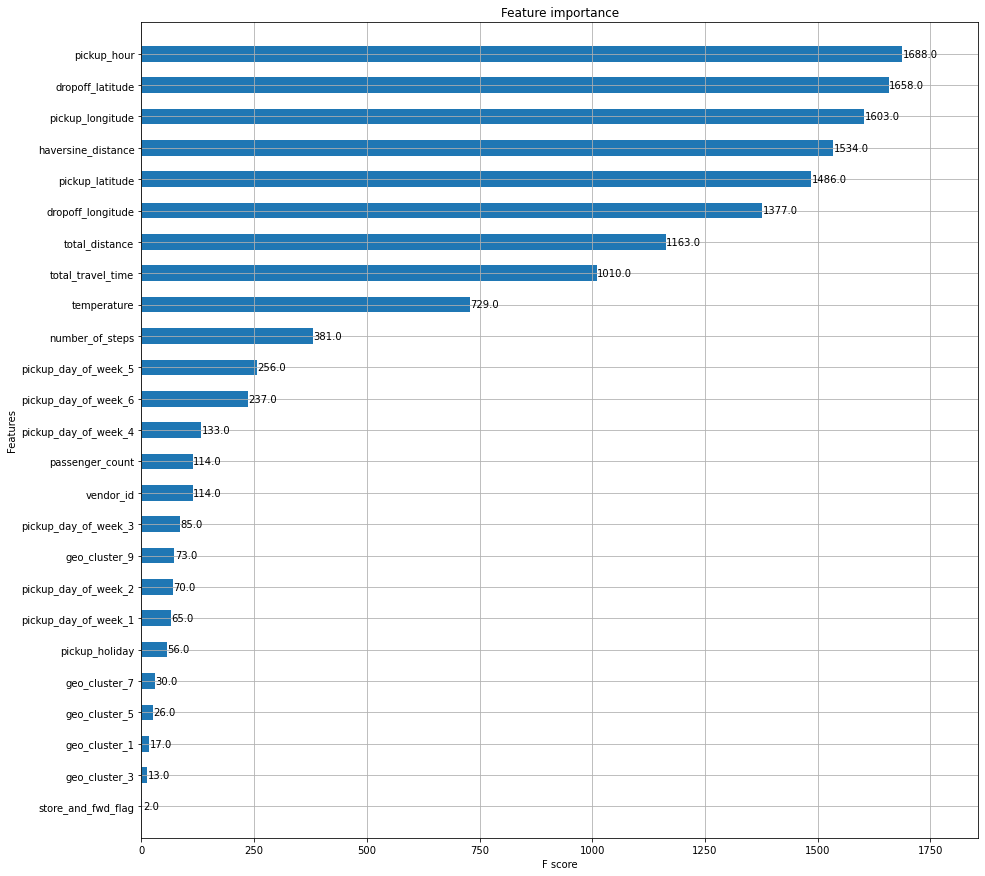

In [106]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)